# Abraia - Getting started with image classification

In [1]:
%%capture
!python -m pip install abraia

import os
if not os.getenv('ABRAIA_ID') and not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/" target="_blank">Get your Abraia Id and Key</a>
    abraia_id = ''  #@param {type: "string"}
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_ID=$abraia_id
    %env ABRAIA_KEY=$abraia_key

#@markdown <a href="https://abraia.me/console/gallery" target="_blank">Upload and manage your images</a>

import numpy as np
import matplotlib.pyplot as plt
from abraia import Multiple, deep
 
multiple = Multiple()

ModuleNotFoundError: No module named 'tensorflow'

# Cats and Dogs transfer learning

Download the cats and dogs dataset and plot some random images.

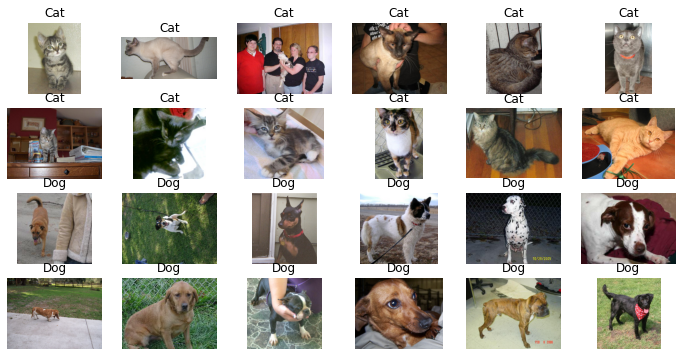

In [ ]:
cat_paths, dog_paths, labels = deep.load_dataset(dataset='cats-and-dogs')

# Show batch
cats = np.random.choice(cat_paths, 12)
dogs = np.random.choice(dog_paths, 12)
data = np.concatenate((cats, dogs))
names = 12 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 4, 6
plt.figure(figsize=(12, 6))
for k, (src, label) in enumerate(zip(data, names)):
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(plt.imread(src))
    plt.axis('off')

## Data augmentation

Split the original dataset for training and validation, prepare training data for data augmentation, and plot some resulting images.

Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


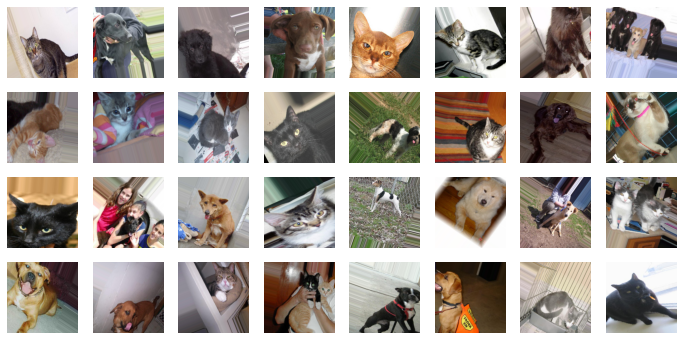

In [ ]:
from abraia.deep import keras
from abraia.deep import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

BATCH_SIZE = 32
target_size = (299, 299)
input_shape = (*target_size, 3)

TRAIN_DIR, TEST_DIR = deep.split_train_test(cat_paths, dog_paths, train_ratio=0.7)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

Epoch 1/5
480/547 [=========================>....] - ETA: 53s - loss: 0.0905 - accuracy: 0.9684

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


547/547 [==============================] - 526s 953ms/step - loss: 0.0861 - accuracy: 0.9696 - val_loss: 0.0240 - val_accuracy: 0.9917
Epoch 2/5
547/547 [==============================] - 518s 946ms/step - loss: 0.0548 - accuracy: 0.9817 - val_loss: 0.0298 - val_accuracy: 0.9908
Epoch 3/5
547/547 [==============================] - 508s 929ms/step - loss: 0.0531 - accuracy: 0.9823 - val_loss: 0.0208 - val_accuracy: 0.9928
Epoch 4/5
547/547 [==============================] - 512s 935ms/step - loss: 0.0550 - accuracy: 0.9826 - val_loss: 0.0218 - val_accuracy: 0.9932
Epoch 5/5
547/547 [==============================] - 513s 938ms/step - loss: 0.0520 - accuracy: 0.9829 - val_loss: 0.0249 - val_accuracy: 0.9923


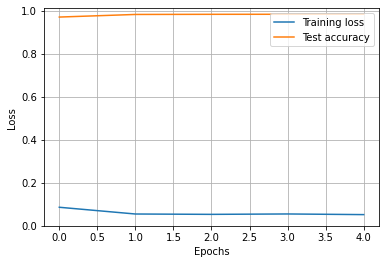

In [ ]:
model = deep.create_model('inception3', 2)
model.train(train_generator, validation_generator)
model.plot_history()

## Prediction of the custom model

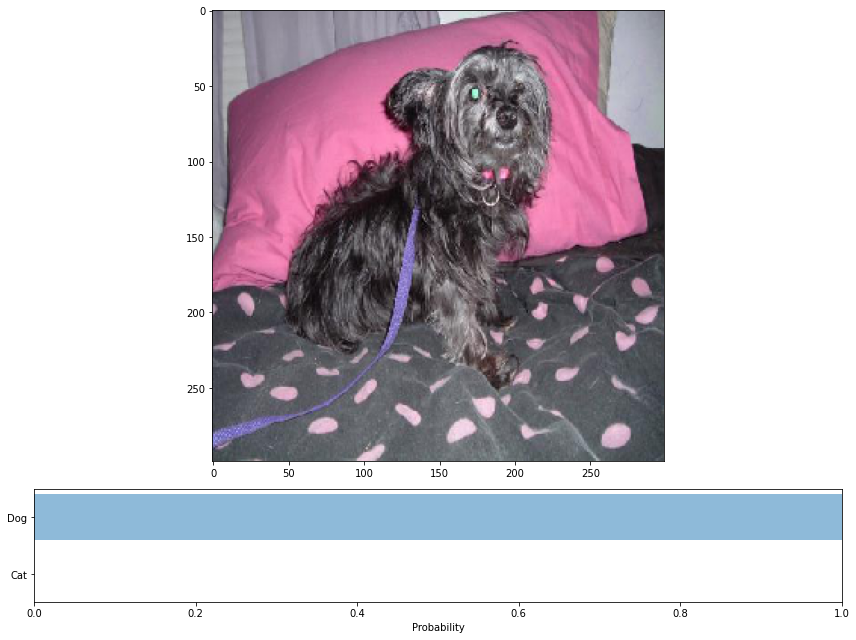

In [ ]:
img = np.asarray(deep.load_img('test/Dog/0.jpg', target_size=target_size))
preds = model.predict(img)
deep.plot_image(img, labels[np.argmax(preds)])